This notebook walks through the preprocessing/QA workflow described in the course slides.

Importing modules

In [1]:
import os, errno
try:
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/myconnectome/sub00001'
print 'Using data from',datadir

%matplotlib inline

from nipype.interfaces import fsl, nipy
import nibabel
import numpy
import nilearn.plotting
import matplotlib.pyplot as plt
from compute_fd_dvars import compute_fd,compute_dvars
from nipype.caching import Memory
mem = Memory(base_dir='.')
results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    
def force_symlink(file1, file2):
    try:
        os.symlink(file1, file2)
    except OSError, e:
        if e.errno == errno.EEXIST:
            os.remove(file2)
            os.symlink(file1, file2)

Using data from /home/vagrant/data


Setting up variables

In [2]:
subject='ses014'  

bolddir=os.path.join(datadir,'ds031/sub00001',subject,
        'functional')
boldfile=os.path.join(bolddir,'sub00001_ses014_task002_run001_bold.nii.gz')


## Motion correction using MCFLIRT

This will take about a minute.

In [3]:
mcflirt = mem.cache(fsl.MCFLIRT)
mcflirt_results = mcflirt(in_file=boldfile,
                  save_plots=True,
                  mean_vol=True)
mcflirt_results.outputs

INFO:workflow:Executing node 39158ff31e7e5890e03f738b49a7c455 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/39158ff31e7e5890e03f738b49a7c455
INFO:workflow:Collecting precomputed outputs



mat_file = <undefined>
mean_img = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/39158ff31e7e5890e03f738b49a7c455/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg.nii.gz
out_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/39158ff31e7e5890e03f738b49a7c455/sub00001_ses014_task002_run001_bold_mcf.nii.gz
par_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/39158ff31e7e5890e03f738b49a7c455/sub00001_ses014_task002_run001_bold_mcf.nii.gz.par
rms_files = <undefined>
std_img = <undefined>
variance_img = <undefined>

We will need the mean EPI image later during the class so we will save it.

In [4]:
force_symlink(mcflirt_results.outputs.mean_img, os.path.join(results_dir, "meanbold.nii.gz"))

Use FSL's BET to obtain the brain mask

In [5]:
bet = mem.cache(fsl.BET)
bet_results = bet(functional=True,
              in_file=mcflirt_results.outputs.mean_img,
              mask=True)
bet_results.outputs

INFO:workflow:Executing node 3e9165655263cb81e8fb760ff4a1d93d in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/3e9165655263cb81e8fb760ff4a1d93d
INFO:workflow:Collecting precomputed outputs



inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/3e9165655263cb81e8fb760ff4a1d93d/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_brain_mask.nii.gz
meshfile = <undefined>
out_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/3e9165655263cb81e8fb760ff4a1d93d/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>

Display the mean image, and show the outline of the brain mask.

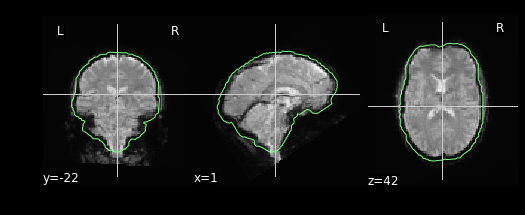

In [6]:
mask_display=nilearn.plotting.plot_epi(mcflirt_results.outputs.mean_img,cmap='gray')
mask_display.add_contours(bet_results.outputs.mask_file, levels=[.5])

Compute and plot the global signal within the mask across timepoints

In [7]:
maskdata=nibabel.load(bet_results.outputs.mask_file).get_data()
bolddata=nibabel.load(mcflirt_results.outputs.out_file).get_data()
maskvox=numpy.where(maskdata)
globalmean=numpy.zeros(bolddata.shape[3])
globalcv=numpy.zeros(bolddata.shape[3])
for t in range(bolddata.shape[3]):
    tmp=bolddata[:,:,:,t]
    globalmean[t]=numpy.mean(tmp[maskvox])
    globalcv[t]=numpy.std(tmp[maskvox])/numpy.mean(tmp[maskvox])

del bolddata


Load motion data and compute FD/DVARS

In [8]:
motiondata=numpy.loadtxt(mcflirt_results.outputs.par_file)
fd=compute_fd(motiondata)
dvars=compute_dvars(globalmean)

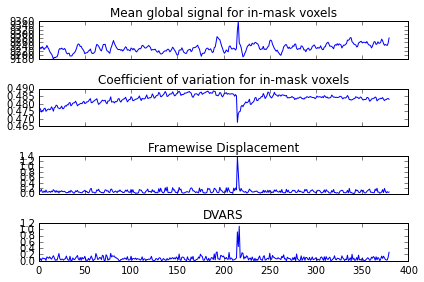

In [9]:
f, (ax1, ax2,ax3,ax4)=plt.subplots(4, sharex=True)
ax1.plot(globalmean)
ax1.set_title('Mean global signal for in-mask voxels')

ax2.plot(globalcv)
ax2.set_title('Coefficient of variation for in-mask voxels')

ax3.plot(fd)
ax3.set_title('Framewise Displacement')

ax4.plot(dvars)
ax4.set_title('DVARS')
plt.tight_layout()

## Performing Independent Component Analysis to look for artefacts

Run independent components analysis on the data using MELODIC - this will take a few minutes.

In [10]:
melodic = mem.cache(fsl.MELODIC)
melodic_results = melodic(out_all=True,
                          report=True,
                          in_files=mcflirt_results.outputs.out_file,
                          mask=bet_results.outputs.mask_file)
melodic_results.outputs

INFO:workflow:Executing node b0cc0b847f9e15720f1ec63660adcc02 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-model-MELODIC/b0cc0b847f9e15720f1ec63660adcc02
INFO:workflow:Collecting precomputed outputs



out_dir = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-model-MELODIC/b0cc0b847f9e15720f1ec63660adcc02
report_dir = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-model-MELODIC/b0cc0b847f9e15720f1ec63660adcc02/report

Check out the MELODIC report

In [11]:
from IPython.display import FileLink
FileLink(os.path.join(melodic_results.outputs.report_dir, '00index.html').split(os.getcwd() + '/')[1])

/home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-model-MELODIC/b0cc0b847f9e15720f1ec63660adcc02/report/00index.html

Load the ICA components and examine their correlation with the motion signals. For components with a correlation > 0.4, show the component voxels.

In [12]:
ica_comps=numpy.loadtxt(os.path.join(melodic_results.outputs.out_dir,'melodic_mix'))

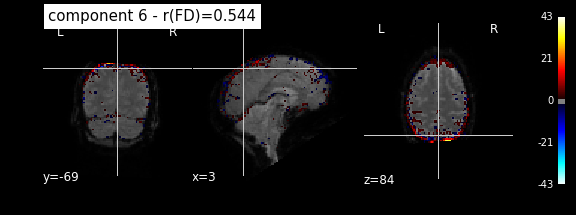

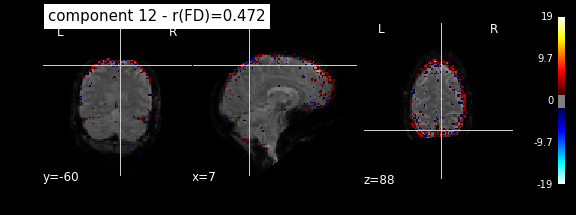

In [13]:
ica_motion_corr=numpy.zeros(ica_comps.shape[1])
for c in range(ica_comps.shape[1]):
    ica_motion_corr[c]=numpy.corrcoef(ica_comps[:,c],fd)[0,1]
    if abs(ica_motion_corr[c])>0.4:
        comp_img=nibabel.load(os.path.join(melodic_results.outputs.out_dir,'stats/thresh_zstat%d.nii.gz'%int(c+1)))
        nilearn.plotting.plot_stat_map(comp_img,mcflirt_results.outputs.mean_img,threshold=1.5,
               title='component %d - r(FD)=%0.3f'%(c+1,ica_motion_corr[c]))
        


## Fieldmap unwarping

Take the first magnitue image and skull strip it

INFO:workflow:Executing node 8e99053e4a0a52d00606114ebae2c576 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/8e99053e4a0a52d00606114ebae2c576
INFO:workflow:Collecting precomputed outputs
INFO:workflow:Executing node c8af9681961f12a6e08902c4c52ab884 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/c8af9681961f12a6e08902c4c52ab884
INFO:workflow:Collecting precomputed outputs


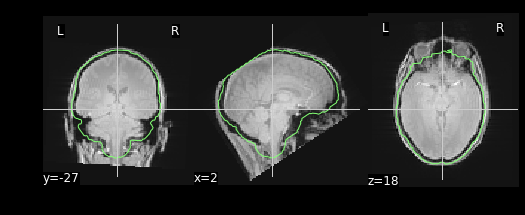

In [14]:
magfile=os.path.join(datadir,'ds031/sub00001',subject,
                'fieldmap/sub00001_ses014_001_magnitude.nii.gz')
roi = mem.cache(fsl.ExtractROI)
pick_first_mag = roi(in_file=magfile, t_min=0, t_size=1)

# we'll need this later
force_symlink(pick_first_mag.outputs.roi_file, os.path.join(results_dir, "fmapmag.nii.gz"))

mag_bet_results = bet(functional=True,
                      in_file=pick_first_mag.outputs.roi_file,
                      mask=True)
mag_bet_results.outputs
mask_display=nilearn.plotting.plot_epi(pick_first_mag.outputs.roi_file,cmap='gray')
mask_display.add_contours(mag_bet_results.outputs.mask_file, levels=[.5])

This was not quite tight enough. Let's try with other parameters

INFO:workflow:Executing node 231fbd70901c41c3623dd469eb2ec9a1 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/231fbd70901c41c3623dd469eb2ec9a1
INFO:workflow:Collecting precomputed outputs



inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/231fbd70901c41c3623dd469eb2ec9a1/sub00001_ses014_001_magnitude_roi_brain_mask.nii.gz
meshfile = <undefined>
out_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/231fbd70901c41c3623dd469eb2ec9a1/sub00001_ses014_001_magnitude_roi_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>

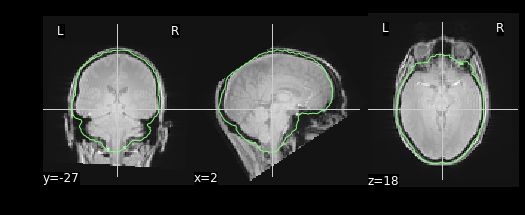

In [15]:
mag_bet_results = bet(functional=True,
                      in_file=pick_first_mag.outputs.roi_file,
                      mask=True,
                      frac=0.65)
force_symlink(mag_bet_results.outputs.out_file, os.path.join(results_dir, "fmapmagbrain.nii.gz"))
mask_display=nilearn.plotting.plot_epi(pick_first_mag.outputs.roi_file,cmap='gray')
mask_display.add_contours(mag_bet_results.outputs.mask_file, levels=[.5])
mag_bet_results.outputs

Prepare the fieldmap

In [16]:
prepare = mem.cache(fsl.PrepareFieldmap)
prepare_results = prepare(in_phase = os.path.join(datadir,'ds031/sub00001',subject,
                                                  'fieldmap/sub00001_ses014_001_phasediff.nii.gz'),
                          in_magnitude = mag_bet_results.outputs.out_file,
                          output_type = "NIFTI_GZ")
force_symlink(prepare_results.outputs.out_fieldmap, os.path.join(results_dir, "fieldmap.nii.gz"))
prepare_results.outputs

INFO:workflow:Executing node b77198f04ba5bba75a28df60023f88a5 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-epi-PrepareFieldmap/b77198f04ba5bba75a28df60023f88a5
INFO:workflow:Collecting precomputed outputs



out_fieldmap = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-epi-PrepareFieldmap/b77198f04ba5bba75a28df60023f88a5/sub00001_ses014_001_phasediff_fslprepared.nii.gz

Which parts of the brain were most deformed by B0 inhomogeneities?

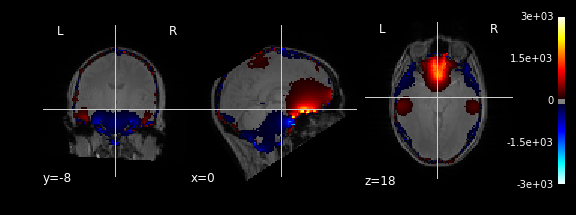

In [ ]:
nilearn.plotting.plot_stat_map(nilearn.image.index_img(prepare_results.outputs.out_fieldmap,0), 
                               pick_first_mag.outputs.roi_file, threshold=100)

Note that we don't really apply these transformations yet. We'll do it after first level modelling

## Spatial smoothing

Perform spatial smoothing using Gaussian kernel. Can you spot the difference between top and bottom rows?

INFO:workflow:Executing node 9ed04d38f1bfce472e5c8eba4c2c708f in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-utils-Smooth/9ed04d38f1bfce472e5c8eba4c2c708f
INFO:workflow:Collecting precomputed outputs


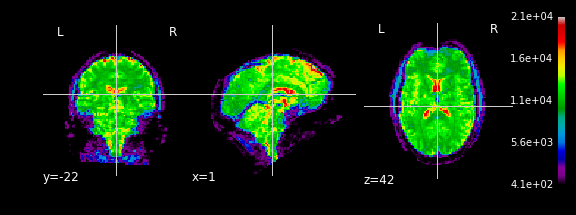

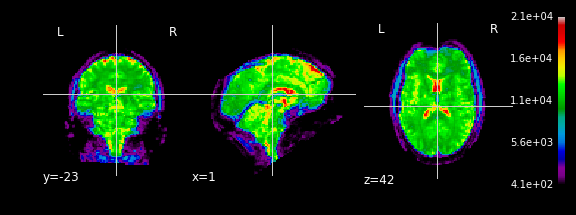

In [ ]:
smooth = mem.cache(fsl.utils.Smooth)
smooth_results = smooth(fwhm=2.5,
                        in_file=mcflirt_results.outputs.out_file)

nilearn.plotting.plot_epi(mcflirt_results.outputs.mean_img,colorbar=True, vmin=410, vmax=21000)
nilearn.plotting.plot_epi(nilearn.image.mean_img(smooth_results.outputs.smoothed_file), colorbar=True, vmin=410, vmax=21000)

## High pass filtering

High-pass filtering - this will take a few minutes

In [ ]:
hpfilt = mem.cache(fsl.maths.TemporalFilter)
hpcutoff = 120
TR = 1.16
hpfilt_results = hpfilt(highpass_sigma = hpcutoff/TR,
                        in_file=smooth_results.outputs.smoothed_file)

binarymaths = mem.cache(fsl.maths.BinaryMaths)
rescale_results = binarymaths(operation = 'add', 
                              in_file=hpfilt_results.outputs.out_file,
                              operand_file=mcflirt_results.outputs.mean_img
                              )

INFO:workflow:Executing node 355114233af530aee337169ff7013ad4 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-maths-TemporalFilter/355114233af530aee337169ff7013ad4
INFO:workflow:Running: fslmaths /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-utils-Smooth/9ed04d38f1bfce472e5c8eba4c2c708f/sub00001_ses014_task002_run001_bold_mcf_smooth.nii.gz -bptf 103.448276 -1.000000 /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-maths-TemporalFilter/355114233af530aee337169ff7013ad4/sub00001_ses014_task002_run001_bold_mcf_smooth_filt.nii.gz


Exercise: Plot the power spectrum for a voxel to look at the effects of filtering